# Hands-On Predicción de Enlaces con GNN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%202%20-%20Graph%20Neural%20Networks/link-prediction.ipynb)

En este notebook implementaremos un modelo Variational Graph Autoencoder para una tarea de predicción de enlaces.

#### Referencias
- [Introduction: Hands-On Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing)
- [Pytorch Geometric - Colab Notebooks and Video Tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)
- [Hands-On Graph Neural Networks Using Python](https://www.amazon.com/Hands-Graph-Neural-Networks-Python/dp/1804617520/ref=sr_1_1?crid=3A0QN1RYH7QQP&dib=eyJ2IjoiMSJ9.-qrnI2P8riRrQ4N6OPe1T9dfnkNhYgbD_-VhWVg_MfGU6D4U1TYZdUeJzAAZ1zhM7oyFoU7g3g3DppC-4DGSfmfmBfPUimLKlEKzBnujFTDHedtcSZuiN9EbIyNLxgkYbwfb0Nq4XhQQQZlS4JYFrBs0-rpkS8EmRz1o2OEJ0qrL9EXU9EJuj9cxCWt7J5HFE4nrJJYOPsX9aI78tp1LAEJqdUW14r9RbOYob9JQK0M.wej4dkKelg8wk6GVu5yxbMuiXefgjxhK-E-2n4_dFBs&dib_tag=se&keywords=hands+on+graph+neural+networks+using+python&qid=1713378267&sprefix=handson+gra%2Caps%2C197&sr=8-1)
- https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.VGAE.html?highlight=vgae

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [2]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/Unidad%202%20-%20Graph%20Neural%20Networks/requirements.txt && pip install -r requirements.txt

In [3]:
if IN_COLAB:
    import torch

    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Funciones utilitarias

Primero, definimos unas cuantas funciones utilitarias para visualizar los grafos. Simplemente añadimos una función más para dibujar más de un grafo a la vez.

In [4]:
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Any, Dict, Tuple
from torch_geometric.data import Dataset
from torch_geometric.data.data import BaseData

seed = 126534
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


def visualize_graph(G, color: str):
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, k=0.05, seed=seed),
        node_size=10,
        with_labels=False,
        node_color=color,
        cmap="Set2",
        width=0.15
    )
    plt.show()


def visualize_graphs(graphs: Dict[str, Dict[str, Any]]):
    fig, axs = plt.subplots(nrows=1, ncols=len(graphs), figsize=(30, 10))
    axs = axs.flatten()
    for idx, key in enumerate(graphs.keys()):
        G = graphs[key]['graph']
        classes = graphs[key]['classes']
        nx.draw_networkx(
            G,
            pos=nx.spring_layout(G, k=0.05, seed=seed),
            node_size=10,
            with_labels=False,
            node_color=classes,
            cmap="Set2",
            width=0.15,
            ax=axs[idx]
        )
        axs[idx].set_title(key)

    plt.show()

def print_dataset_summary(dataset: Dataset):
    print(f'Dataset: {dataset}')
    print(f'=' * 20)
    print(f'Número de grafos: {len(dataset)}')
    print(f'Número de features: {dataset.num_features}')
    print(f'Número de clases: {dataset.num_classes}')


def print_graph_summary(data: BaseData):
    print(f'=' * 50)
    print(f'Número de nodos: {data.num_nodes}')
    print(f'Número de conexiones: {data.num_edges}')
    print(f'Grado promedio: {data.num_edges / data.num_nodes:.2f}')

## Amazon Products Dataset

Para este ejemplo cambiaremos de conjunto de datos y utilizaremos un dataset de productos de Amazon. Concretamente, usaremos el sub conjunto "Computers" el cual consta de mas de 13 mil nodos y casi medio millon de enlaces.

Este dataset es parte del paper ["Pitfalls of Graph Neural Network Evaluation"](https://arxiv.org/abs/1811.05868) cuyo objetivo era evaluar métricas sobre redes neuronales grafales.

En concreto, Amazon Computers es un segmento de compra de productos que fueron comprados juntos en la tienda de amazon. Es decir aquellos que son frecuentemente comprados juntos. Es natural imaginar el propósito y utilidad de este conjunto, los sistemas de recomendación, aunque puede ir más allá y servir como guía a reabastecimiento de inventarios.

Para esta tarea nos interesa solamente predecir los enlaces, por lo que las clases no serán de importancia en el desarrollo de esta tarea. Solamente se tendrán en cuenta para propósitos ilustrativos.

#### Referencias
- [Amazon (Dataset)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Amazon.html#torch_geometric.datasets.Amazon)
- [Pitfalls of Graph Neural Network Evaluation](https://arxiv.org/abs/1811.05868)

In [5]:
from torch_geometric.datasets import Amazon
from torch_geometric.transforms import RandomLinkSplit


link_splitter = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False)
dataset = Amazon(root='./amazon-products', name='Computers')
data = dataset[0]

# Para limitar el dataset, descomentar las dos lineas siguientes. Agilizará el entrenamiento para propósitos experimentales
# subset_size = 5000
# data = data.subgraph(torch.randint(low=0, high=data.x.shape[0], size=(subset_size,)))

train_data, val_data, test_data = link_splitter(data)
print_dataset_summary(dataset)
print_graph_summary(train_data)

Dataset: AmazonComputers()
Número de grafos: 1
Número de features: 767
Número de clases: 10
Número de nodos: 13752
Número de conexiones: 417964
Grado promedio: 30.39


Ahora, visualicemos el grafo. 

Como este grafo es más grande que los que hemos estado trabajando, para propósitos demostrativos, vamos a sacar un subgrafo solo para visualización.

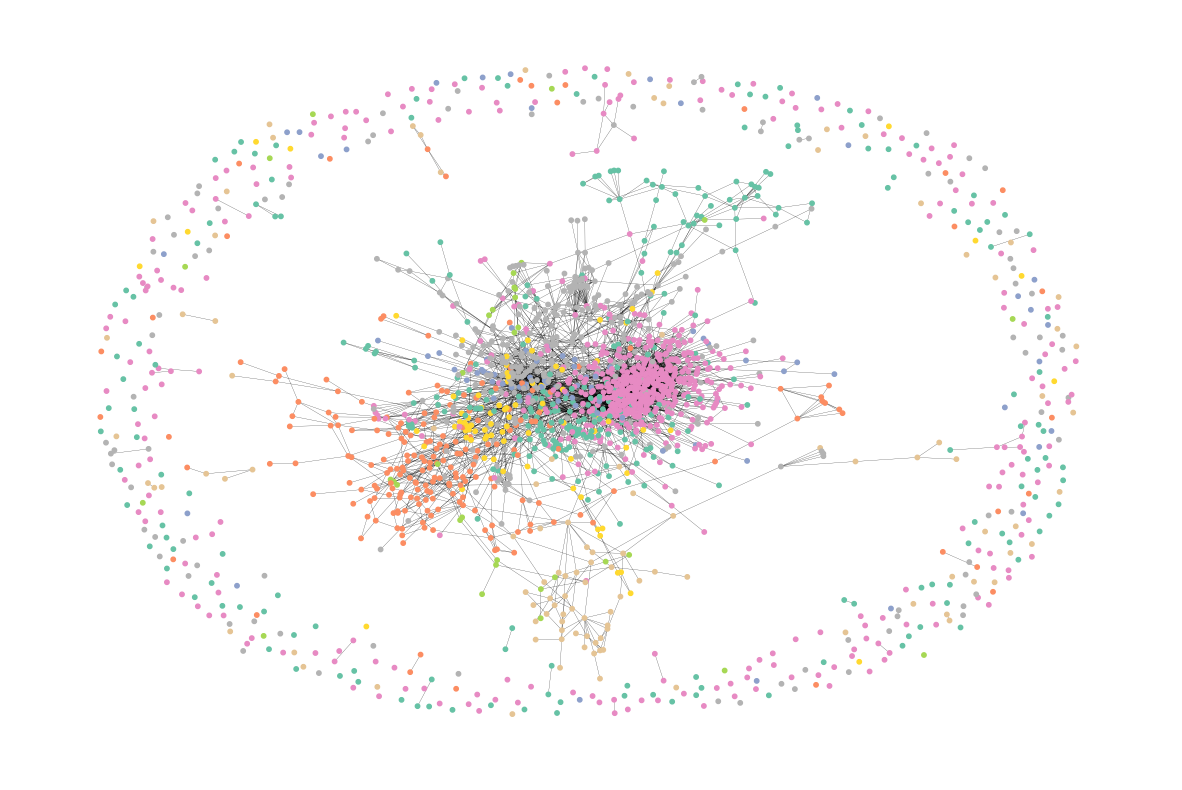

In [19]:
from torch_geometric.utils import to_networkx

subset = torch.randint(low=0, high=train_data.x.shape[0], size=(2000,))
train_subgraph = train_data.subgraph(subset)
G = to_networkx(train_subgraph, to_undirected=True)
visualize_graph(G, color=train_subgraph.y)

Como se ha mencionado antes, las clases solamente las tendremos en cuenta para propósitos ilustrativos. Como se puede observar, nodos de la misma clase tienden a estar conectados entre si.

### Definición de un modelo VGAE

GAE y VGAE, propuestos por Kipf y Welling, se inspiran en los Autoencoders tradicionales para ser aplicados a grados. Los principios son los mismos. En este caso, en lugar de reconstruir una imagen (uso clasico, pero no único, de los autoencoders), la idea es reconstruir la matriz de adyacencia del grafo en cuestion, a partir de los embeddings $Z$ de los nodos del grafo.

$$
A \approx Z^TZ
$$

Las arquitecturas de los autoencoders se componen de dos partes:

El encoder, que proyecta el grafo en un espacio dimensional reducido $Z$, el cual puede ser cualquier arquitectura de red, en este caso, usaremos Graph Convolutional Networks

$$
Z = GCN(X, A)
$$

Un aspecto importante a destacar entre GAE y VGAE, es que en GAE buscamos proyectar y reconstruir la matriz directamente, mientras que en VGAE lo que hacemos es entrrenar una red que aprenda los parámetros de una probabilidad de distribución de la cual luego se tomarán muestras de embeddings. Esto le brinda mayor flexibilidad a la hora de capturar y generar embeddings con algo de alteatoridad para ejemplares no vistos durante el entrenamiento.

Liego el decoder, que reconstruye la matriz de adyacencia, a partir del producto interno del embedding $Z$

$$
\hat{A} = \sigma(Z^TZ)
$$

Nótese que se añade una función de activación sigmoid a dicho producto, esto es porque buscamos valores entre 1 y 0, es decir, hay o no hay conexión entre dos nodos.

Para entrenar la red, se busca minimizar la diferencia entre la matriz obtenida y la matriz real. Pero además de eso, dada la característica probabilística de la red, debemos contemplar una pérdida adicional que es *KL Divergence*, la cual nos permite comparar probabilidades de distribución. Entonces tenemos:

Binary Cross Entropy Loss, que nos permite calcular la pérdida de la reconstrucción de la matriz con la real.
$$
\mathcal{L}_{BCE} = \sum_{i \in V, j \in V} -A_{ij} \text{log}(\hat{A}_{ij}) - (1 - A_{ij})\text{log}(1 - \hat{A}_{ij})
$$

KL Divergence, que nos permite entrenar para la parte probabilística de la red.
$$
\mathcal{L}_{ELBO}=\mathcal{L}_{BCE} - \text{KL}[q(Z|X,A)||p(Z)]
$$

Donde: 
- $q(Z||X, A)$ es la probabilidad de $Z$ dado el grafo de entrada $X$ y su matriz de adyacencia $A$, esto es equivalente al encoder de la red.
- $p(Z)$ es la probabilidad de observar a $Z$ en general durante el entrenamiento.

##### Referencias
- [Variational Graph Auto-Encoders](https://arxiv.org/abs/1611.07308)

In [7]:
import torch
import torch.nn as nn
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.utils import negative_sampling


class Encoder(nn.Module):
    """Encoder
    Nuesro encoder es una red GCNConv sensilla de dos capas.
    Como necesitamos entregar dos parámetros, mu y sigma,
    necesitamso dos cabezas, aunque ambas pueden
    compartir la primera capa.
    """
    def __init__(self, input_size: int, output_size: int):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(input_size, 2 * output_size)
        self.conv_mu = GCNConv(2 * output_size, output_size)
        self.conv_sigma = GCNConv(2 * output_size, output_size)

    def forward(self, x: torch.Tensor, edge_index) -> torch.Tensor:
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_sigma(x, edge_index)


class VGAELinkPrediction(LightningModule):

    def __init__(self, input_size: int, output_size: int):
        """VGAELinkPrediction

        En nuestro predictor, definimos el encoder y
        un modelo vgae de torch geometric, el cual
        ya implementa la mayoría de las operaciones
        mencionadas arriba, por lo que nos ahorra el
        trabajo de implementar las funciones de pérdida
        y el decoder.

        Pero si fuera necesario, podríamos pasar nuestras
        propias estructuras.
        """
        super(VGAELinkPrediction, self).__init__()
        self.encoder = Encoder(input_size, output_size)
        self.vgae = VGAE(self.encoder)

        self.hparams['vgae'] = str(self.vgae)
        self.save_hyperparameters()

    def forward(self, x: torch.Tensor, edge_index) -> torch.Tensor:
        """forward

        Nuestro forward pass es sencillamente invocar al encoder,
        así obtendrémos vector de embeddings Z
        """
        return self.vgae.encode(x, edge_index)
    
    def predict_links(self, x: torch.Tensor, edge_index) -> torch.Tensor:
        """predict_links

        Este método es un utilitario para hacer predicciones
        de enlaces sobre unos datos de entrada y unos indices de conexion.

        Primero debemos obtener un embedding Z para el grafo de entrada
        y luego lo decodificamos con el edge_index. Obtendrémos un tensor
        con las probabilidades de cada conexión de ser positiva o negativa.
        """
        z = self(x, edge_index)
        return self.vgae.decode(z, edge_index)
    
    @staticmethod
    def edge_labels_to_adj(data, edge_preds: torch.Tensor) -> torch.Tensor:
        """edge_labels_to_adj

        Este es otro método utilitario que convierte las predicciones
        de enlaces (probabilidades de conexión), en su correspondiente
        matriz de adyacencia.

        Como las predicciones son probabilidades, debemos discretizarlas
        en 0 (no conexión) y 1 (conexión).
        """
        num_nodes = data.num_nodes
        adj_matrix = torch.zeros((num_nodes, num_nodes))

        for i, (source, target) in enumerate(data.edge_index.T):
            adj_matrix[source, target] = 1 if edge_preds[i] > 0.5 else 0

        return adj_matrix
        

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        """training_step

        Aquí definimos el proceso de entrenamiento.

        Primero, obtenemos un embedding Z a partir de los datos de entrada,
        luego, calculamos la perdida a partir de las dos pérdidas mecionadas
        anterioremente.

        Primero, la pérdida de reconstrucción (BCE Loss) ponderada por el número
        de nodos y añadimos la KL Divergence loss que nos ofrece VGAE.

        Finalmente, las métricas de evaluación las podemos obtener con la misma clase
        y reportarlas en el experimento.
        """
        x, edge_index = batch.x, batch.edge_index
        z = self(x, edge_index)
        loss = self.vgae.recon_loss(z, batch.edge_label_index) + (1 / batch.num_nodes) * self.vgae.kl_loss()
        auc, ap = self.vgae.test(z, edge_index, negative_sampling(edge_index, z.shape[0]))
        self.log('train-loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train-auc', auc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train-ap', ap, prog_bar=True, on_step=False, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        """validation_step

        Las funciones de validación y prueba hacen lo mismo que la de entrenamiento,
        excepto por el cálculo de pérdida.
        """
        x, edge_index = batch.x, batch.edge_index
        z = self(x, edge_index)
        auc, ap = self.vgae.test(z, edge_index, negative_sampling(edge_index, z.shape[0]))
        self.log('val-auc', auc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val-ap', ap, prog_bar=True, on_step=False, on_epoch=True)


    def test_step(self, batch, batch_idx) -> torch.Tensor:
        x, edge_index = batch.x, batch.edge_index
        z = self(x, edge_index)
        auc, ap = self.vgae.test(z, edge_index, negative_sampling(edge_index, z.shape[0]))
        self.log('test-auc', auc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test-ap', ap, prog_bar=True, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
    

vgae_model = VGAELinkPrediction(dataset.num_features, 32)
tb_logger = TensorBoardLogger('tb_logs', name='VGAELinkPrediction')
callbacks=[EarlyStopping(monitor='train-loss', patience=3, mode='min')]
trainer = Trainer(max_epochs=100, devices=1, logger=tb_logger, callbacks=callbacks)

# Definimos parámetros comunes para todos los data loaders.
data_loader_params = dict(
    num_neighbors=[30, 30],
    edge_label_index= train_data.edge_index,
    neg_sampling="binary",
    batch_size=1024,
    num_workers=4,
    shuffle=True
)

train_loader = LinkNeighborLoader(data=train_data, **data_loader_params)
val_loader = LinkNeighborLoader(data=val_data, **data_loader_params)

trainer.fit(vgae_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 53.3 K
1 | vgae    | VGAE    | 53.3 K
------------------------------------
53.3 K    Trainable params
0         Non-trainable params
53.3 K    Total params
0.213     Total estimated model params size (MB)


Epoch 10: 100%|██████████| 409/409 [06:19<00:00,  1.08it/s, v_num=1, val-auc=0.724, val-ap=0.719, train-loss=1.360, train-auc=0.718, train-ap=0.714]


Ahora observamos el resultado en el conjunto de prueba.

In [8]:
vgae_model.eval()
test_loader = LinkNeighborLoader(data=test_data, **data_loader_params)
trainer.test(vgae_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 409/409 [03:16<00:00,  2.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test-ap             0.719468891620636
        test-auc            0.7255247831344604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test-auc': 0.7255247831344604, 'test-ap': 0.719468891620636}]

### Observando el proceso de entrenamiento

In [9]:
%load_ext tensorboard

In [14]:
%tensorboard --logdir tb_logs/

Reusing TensorBoard on port 6006 (pid 841210), started 0:15:29 ago. (Use '!kill 841210' to kill it.)

En cuanto al proceso de entrenamiento, es posible que observemos un deterioro de la calidad del modelo tras un incremento de la misma. Esto a pesar de que la pérdida sigue decreciendo. Pueden haber múltiples factores para esto. Tengamos en cuenta que estamos entrenando con una pérdida diferente a la métrica de evaluación, por lo que una mejoría en una no necesariamente se tiene que traducir en una mejoría en la otra. Se haría necesario observar la calidad de las predicciones para evaluar mejor que es lo que está sucediendo.

### Haciendo predicciones

Ahora hagamos unas predicciones

In [11]:
def build_output_graph(num_nodes, edge_index, targets):
    graph = nx.Graph()

    graph.add_nodes_from(list(range(num_nodes)))

    for source, target in edge_index.T.tolist():
        graph.add_edge(source, target)

    classes = []
    for node in graph.nodes:
        classes.append(targets[node])

    return graph, classes

Construiremos un grafo con la información de prueba y otro con las predicciones de la red entrenada.

In [17]:
from torch_geometric.utils import dense_to_sparse


subgraph = test_data.subgraph(torch.randint(low=0, high=test_data.num_nodes, size=(2000,)))

# Grafo con la información de prueba
test_graph, test_classes = build_output_graph(subgraph.num_nodes, subgraph.edge_index, subgraph.y)

# Realizamos predicciones con los datos de prueba
preds = vgae_model.predict_links(subgraph.x, subgraph.edge_index)
# Obtenemos la correspondiente matriz de adyacencia a partir de las probabilidades de conexión
pred_adj_matrix = vgae_model.edge_labels_to_adj(subgraph, preds)
# Convertimos la matriz de adyacencia en edge_index (para facilidad de uso)
pred_edge_index, _ = dense_to_sparse(pred_adj_matrix)

pred_graph,_ = build_output_graph(subgraph.num_nodes, pred_edge_index, subgraph.y) 

Finalmente visualizamos ambos grafos.

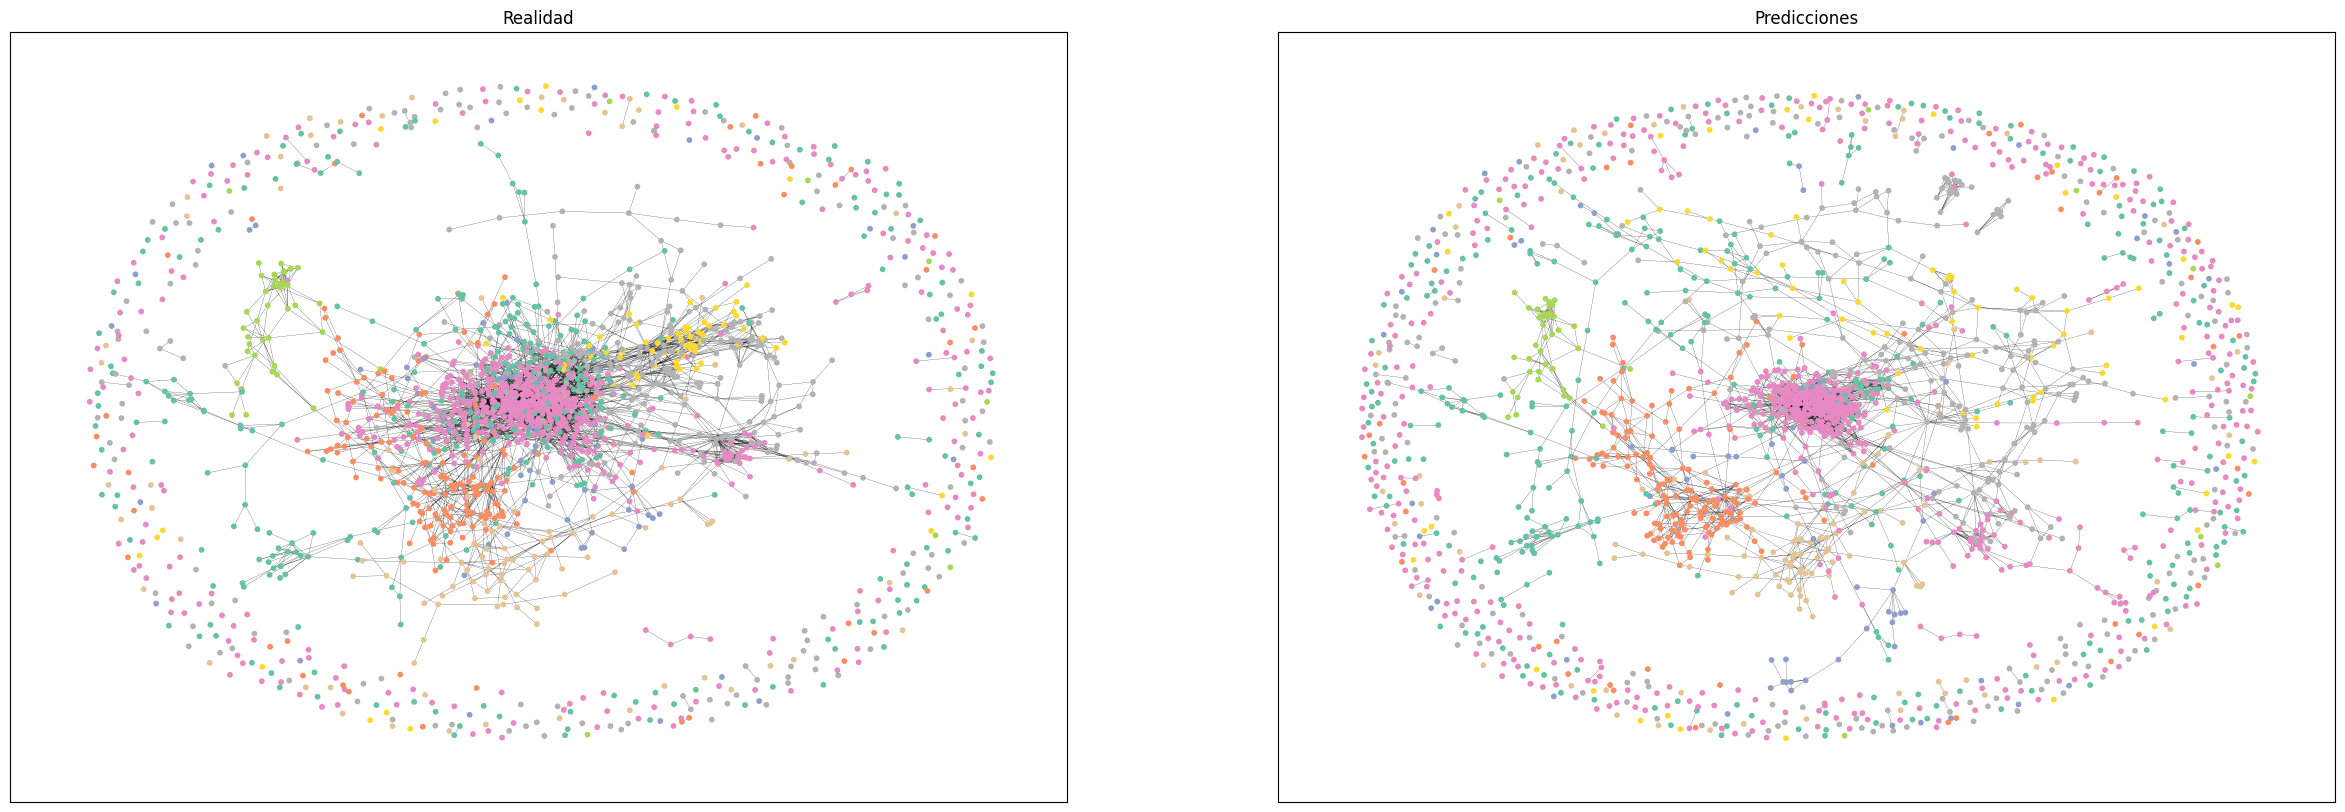

In [18]:
visualize_graphs(
    {
        'Realidad': dict(graph=test_graph, classes=test_classes),
        'Predicciones': dict(graph=pred_graph, classes=test_classes),
    }
)

## Conclusiones
- Como se puede observar, el modelo puede reconstruir ciertas conexiones del grafo original, sin embargo, añade otras conexiones que originalmente no estaban allí.
- Respecto a las conexiones nuevas que no veíamos en el grafo original, resulta interesante observar que estas en efecto tienden a ser entre nodos del mismo tipo. Esto puede interpretarse de dos formas:
    - Errores de predicción, por los que debemos entrar a hacer un análisis de errores.
    - El modelo podría estarnos indicando que efectivamente los items de las nuevas conexiones tienen probabilidad de comprarse juntos y depende del caso de uso si conviene interpretarlo de esa manera o no.
- Nuevamente, resulta interesante observar que muchas de las conexiones nuevas que observamos, son de nodos de la misma clase y cabe resaltar una vez más que durante el proceso de entrenamiento nunca usamos las clases de los nodos, por lo que podemos inferir que estas relaciones podrían ser orgánicas.
- Naturalmente, en el caso de que consideremos estas nuevas relaciones como orgánicas, es preciso hacer una análisis de esto pues debemos ser realistas según el caso. Si estas relaciones son por ejemplo de productos sustitutos, no tiene sentido asumir que en todos los casos, al comprar un producto A, SIEMPRE se van a comprar los productos B y C siendo estos últimos del mismo tipo y características. Aquí se hace necesario saber utilizar el resultado de forma astuta.
- Una reconstrucción aproximada a la matriz de adyacencia original nos permitiría hacer predicciones sobre grafos no vistos durante el entrenamiento y hacer recomendaciones de productos a personas que estén comprando un item relacionado en su grafo.